In [1]:
import os
import shutil
import datetime
import numpy as np
import pandas as pd
from scipy.io import loadmat
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error
from sklearn import metrics
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
import random
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from tensorflow.keras import backend as K

# Dataset loading and preprocessing

#### Removing anomalies and fitting a polynomial line through the SoH values to compute the physics loss function.


#### Standardizing the values of features and selecting the appropriate features based on the correlation matrix.


#### SoH values are obtained by dividing capacity of the battery at any timestep t by the maximum value of capacity.

In [2]:
def get_positional_encodings(sequence_length, d_model):
    PE = np.zeros((sequence_length, d_model))
    positions = np.arange(sequence_length)[:, np.newaxis]
    dimension_indices = np.arange(d_model)[np.newaxis, :]
    div_term = 10000 ** (2 * (dimension_indices // 2) / d_model)
    PE[:, 0::2] = np.sin(positions / div_term[:, 0::2])
    PE[:, 1::2] = np.cos(positions / div_term[:, 1::2])
    return PE

lst = []
sc = MinMaxScaler(feature_range=(0, 1))
directory = '/kaggle/input/soh-data-mit/data'

for filename in os.listdir(directory):
    f = os.path.join(directory, filename)
    df = pd.read_csv(f)
    C = max(df['capacity'])
    SoH = np.array(df['capacity'] / C)
    df_transformed = pd.DataFrame(sc.fit_transform(df), columns=df.columns)
    df_transformed['SoH'] = SoH
    df_transformed = df_transformed.drop(columns = ['capacity','current slope','current std','current entropy'])
#     PE = get_positional_encodings(len(df), 16)
#     for i in range(16):
#         df_transformed[f'PE_{i}'] = PE[:, i]
    lst.append(df_transformed)

data = []

threshold = 0.03

index = [19,52,56,63,89]

for i in range(len(lst)):
    if i in index:
        continue
    df = pd.DataFrame(lst[i])
    y = np.array(df['SoH'])
    x = np.arange(len(df)).reshape(-1, 1)
    degree = 4 
    poly = PolynomialFeatures(degree=degree)
    X_poly = poly.fit_transform(x)
    model = LinearRegression()
    model.fit(X_poly, y)
    y_pred = model.predict(X_poly)
    df['SoH_pred'] = y_pred
    indices = []
    for _ in range(len(df)):
        if abs(y_pred[_]-y[_])<threshold:
            indices.append(True)
        else:
            indices.append(False)
    df = df[indices]
    data.append(df)

In [3]:
data[0].columns

Index(['voltage mean', 'voltage std', 'voltage kurtosis', 'voltage skewness',
       'CC Q', 'CC charge time', 'voltage slope', 'voltage entropy',
       'current mean', 'current kurtosis', 'current skewness', 'CV Q',
       'CV charge time', 'SoH', 'SoH_pred'],
      dtype='object')

# EDA

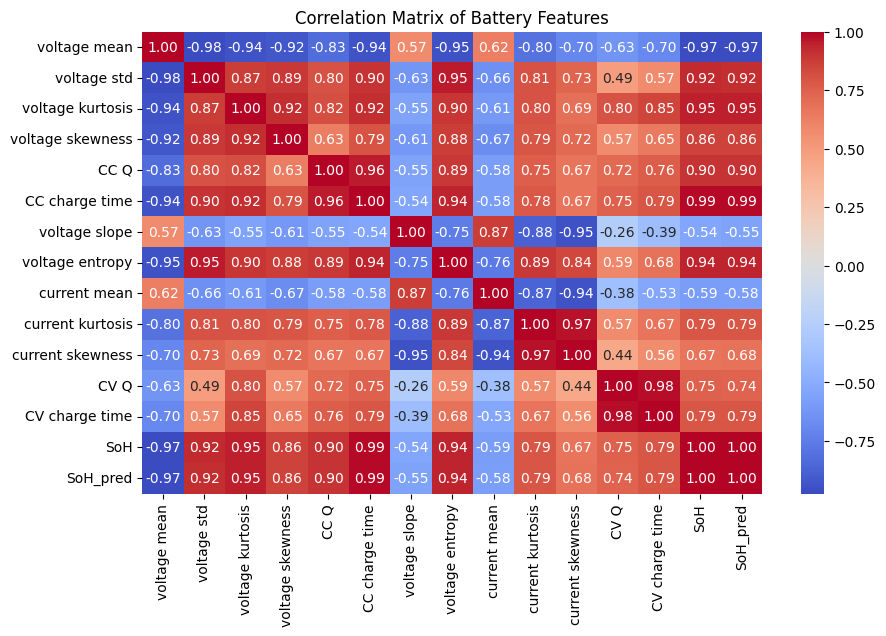

In [4]:
# Correlation matrix
df = pd.DataFrame(data[0])
# df = df.drop(columns = [ 'PE_0', 'PE_1', 'PE_2', 'PE_3', 'PE_4', 'PE_5',
#        'PE_6', 'PE_7', 'PE_8', 'PE_9', 'PE_10', 'PE_11', 'PE_12', 'PE_13',
#        'PE_14', 'PE_15'])
correlation_matrix = df.corr()
compilation_matrix = np.copy(correlation_matrix)
for i in range(len(data)-1):
    df = pd.DataFrame(data[0])
#     df = df.drop(columns = [ 'PE_0', 'PE_1', 'PE_2', 'PE_3', 'PE_4', 'PE_5',
#        'PE_6', 'PE_7', 'PE_8', 'PE_9', 'PE_10', 'PE_11', 'PE_12', 'PE_13',
#        'PE_14', 'PE_15'])
    correlation_matrix = df.corr()
    compilation_matrix+=correlation_matrix
compilation_matrix/=len(data)
plt.figure(figsize=(10, 6))
sns.heatmap(compilation_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title('Correlation Matrix of Battery Features')
plt.show()

# Model

In [5]:
def create_model(input_shape):
    model = tf.keras.Sequential()
    model.add(tf.keras.layers.Dense(units=256, activation='tanh', input_shape=input_shape))
    model.add(tf.keras.layers.Dense(units=128, activation='tanh'))
    model.add(tf.keras.layers.Dropout(0.3))
    model.add(tf.keras.layers.Dense(units=64, activation='tanh'))
    model.add(tf.keras.layers.Dense(units=32, activation='tanh'))
    model.add(tf.keras.layers.Dense(units=1, activation='tanh'))
    return model

In [6]:
def custom_loss(y_true_soh_pred, y_pred):
    y_true = y_true_soh_pred[:, 0:1]  
    soh_pred = y_true_soh_pred[:, 1:2]  
    data_loss = K.mean(K.square(y_true - y_pred))
    physics_loss = K.mean(K.square(soh_pred - y_pred))
    total_loss = data_loss + 0.1*physics_loss
    return total_loss

In [7]:
PINN = create_model((data[0].shape[1]-2,))
PINN.compile(optimizer=Adam(learning_rate = 1e-4), loss=custom_loss,metrics = ['mse'])

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [8]:
PINN.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 256)            │         3,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_4 (Dense)                 │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 46,849 (183.00 KB)

 Trainable params: 46,849 (183.00 KB)

 Non-trainable params: 0 (0.00 B)

In [9]:
import random
random.shuffle(data)
train  = data[5:]
test = data[:5]

In [10]:
loss = []
epochs = 20
for epoch in range(epochs):
    epoch_loss = 0  
    batches = 0 
    random.shuffle(train)
    for i in range(len(train)):
        df = pd.DataFrame(train[i])
        indices = np.random.permutation(len(df))
        y = np.array(df['SoH']).reshape(-1, 1)
        y = y[indices]
        pred = np.array(df['SoH_pred']).reshape(-1, 1)
        pred = pred[indices]
        df = df.drop(columns=['SoH','SoH_pred'])
        y_combined = np.concatenate([y, pred], axis=1)
        X = np.array(df)
        X = X[indices]    
        history = PINN.fit(X, y_combined, epochs=1, batch_size=8,verbose=0)
        batch_loss = history.history['loss'][0]  
        epoch_loss += batch_loss 
        batches += 1
    avg_epoch_loss = epoch_loss
    loss.append(epoch_loss)
    print(f'Epoch {epoch + 1}/{epochs}, Loss: {avg_epoch_loss:.4f}')

Epoch 1/20, Loss: 0.0953
Epoch 2/20, Loss: 0.0056
Epoch 3/20, Loss: 0.0043
Epoch 4/20, Loss: 0.0034
Epoch 5/20, Loss: 0.0052
Epoch 6/20, Loss: 0.0037
Epoch 7/20, Loss: 0.0037
Epoch 8/20, Loss: 0.0029
Epoch 9/20, Loss: 0.0028
Epoch 10/20, Loss: 0.0036
Epoch 11/20, Loss: 0.0026
Epoch 12/20, Loss: 0.0032
Epoch 13/20, Loss: 0.0026
Epoch 14/20, Loss: 0.0035
Epoch 15/20, Loss: 0.0030
Epoch 16/20, Loss: 0.0030
Epoch 17/20, Loss: 0.0032
Epoch 18/20, Loss: 0.0028
Epoch 19/20, Loss: 0.0026
Epoch 20/20, Loss: 0.0025


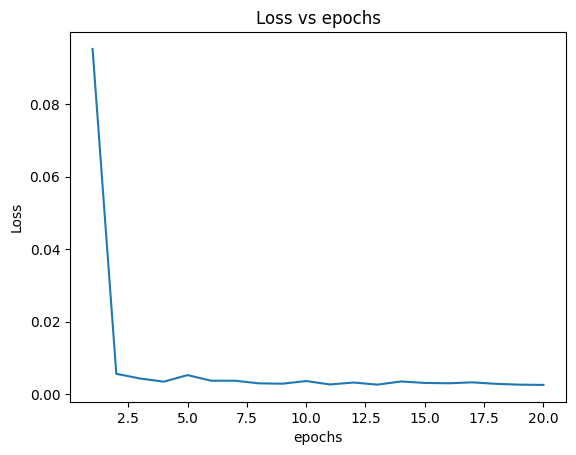

In [11]:
x_ax = np.arange(epochs)+1
plt.plot(x_ax,loss)
plt.title('Loss vs epochs')
plt.ylabel('Loss')
plt.xlabel('epochs')
plt.show()

18/18 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
(560,) (560,)



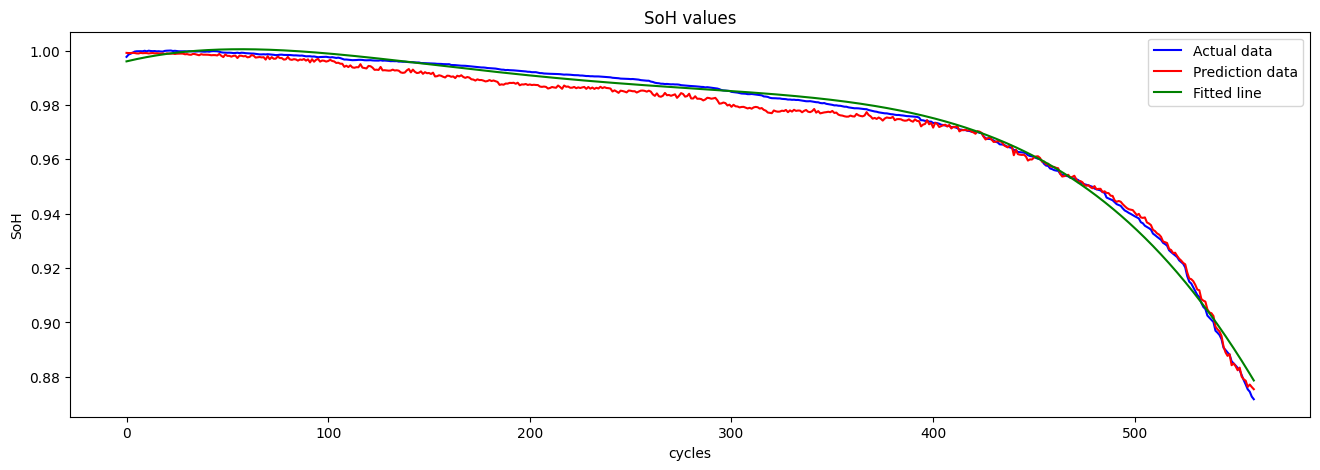

14/14 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
(426,) (426,)



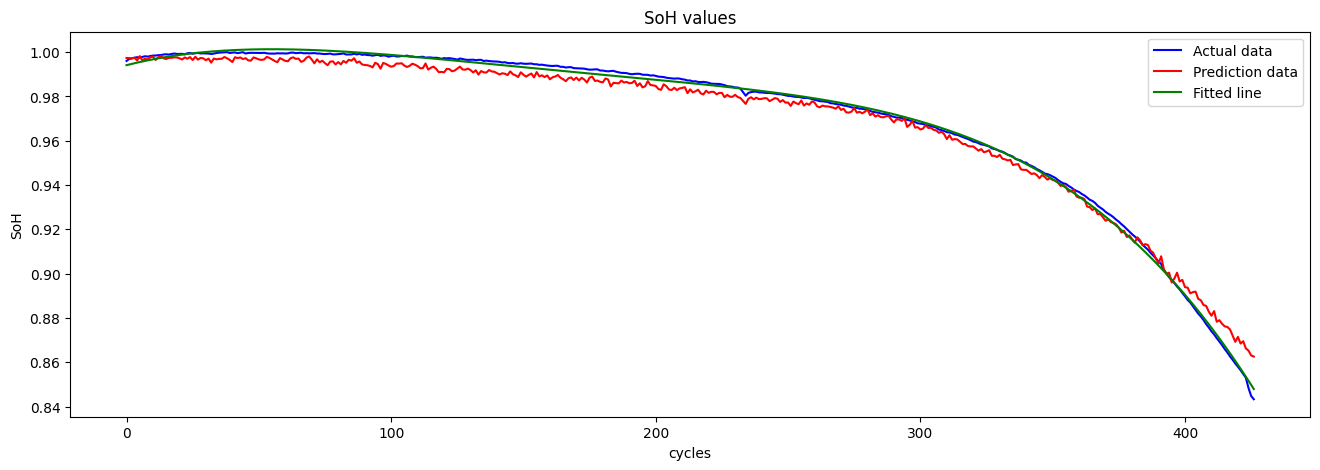

12/12 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
(360,) (360,)



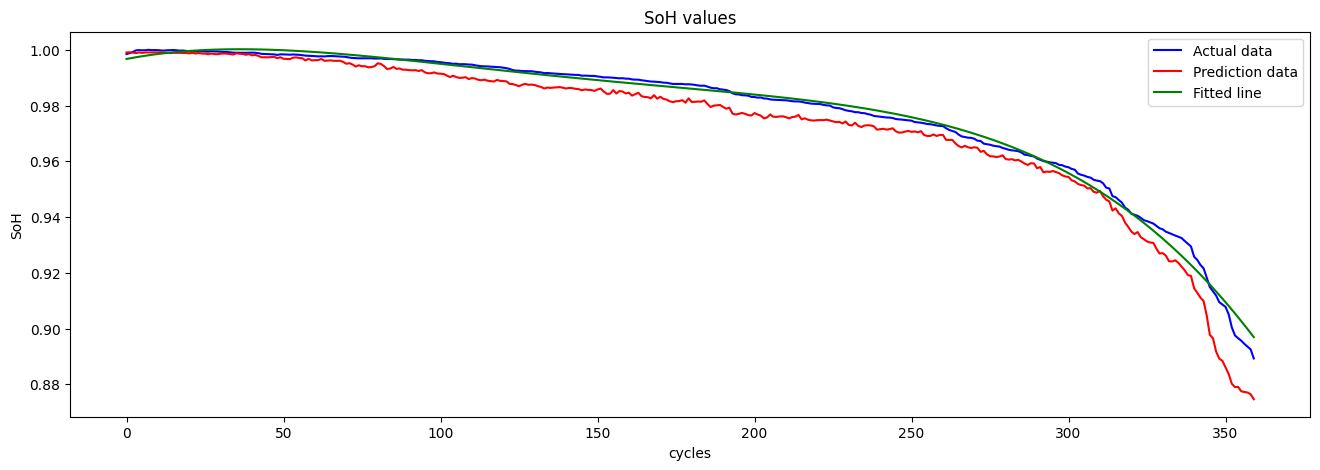

26/26 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
(805,) (805,)



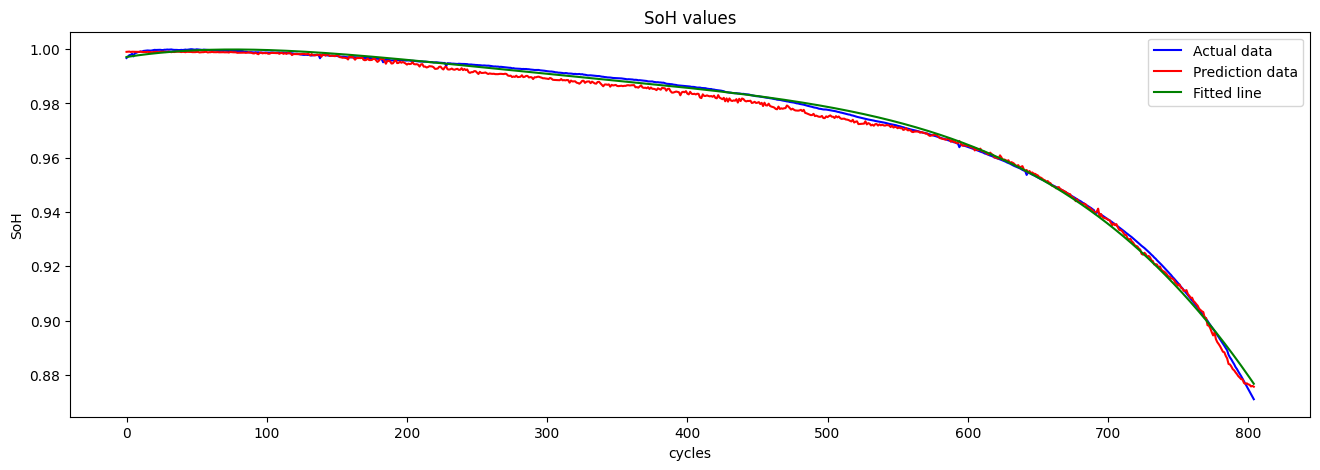

16/16 ━━━━━━━━━━━━━━━━━━━━ 0s 1ms/step 
(505,) (505,)



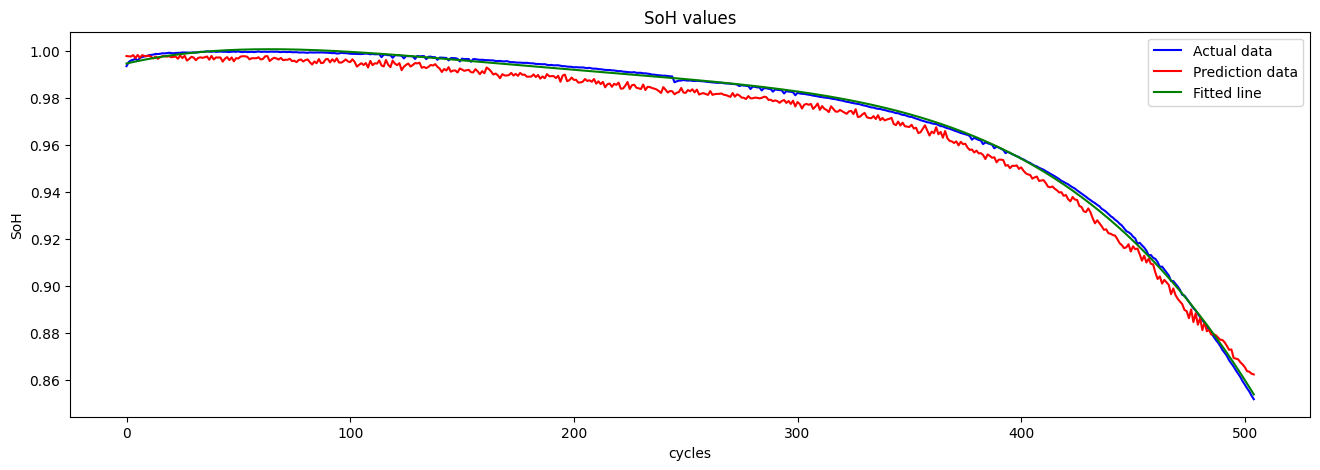

R2_score: 0.9785356174483546, MSE: 1.7988075104849475e-05, MAE: 0.0033537466059568657, 


In [14]:
R2 = []
MSE = []
MAE = []
for i in range(len(test)):
    df = pd.DataFrame(test[i])
    y = np.array(df['SoH'])
    z = np.array(df['SoH_pred'])
    df = df.drop(columns  = ['SoH','SoH_pred'])
    X  = np.array(df)
    pred = PINN.predict(X).reshape(len(y),)
    print(y.shape,pred.shape)
    r2 = r2_score(y,pred)
    R2.append(r2)
    mse = mean_squared_error(y,pred)
    MSE.append(mse)
    mae = mean_absolute_error(y,pred)
    MAE.append(mae)
    print()#r2,mse,mae)
    plt.figure(figsize=(16, 5))
    plt.plot(df.index, y, label="Actual data", color='blue')
    plt.plot(df.index, pred,label="Prediction data", color='red')
    plt.plot(df.index, z,label="Fitted line", color='green')
    plt.title('SoH values')
    plt.xlabel('cycles')
    plt.ylabel('SoH')
    plt.legend()
    plt.show()
print(f'R2_score: {np.mean(R2)}, MSE: {np.mean(MSE)}, MAE: {np.mean(MAE)}, ')